# Negative Laplacian experiment

This code attempts to learn a Laplacian prior J(x) = -|x| assuming we have access to a bunch of observations S(yi) = min_{x \in \R} 0.5*||x-yi||^{2}_{2} + J(x).

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from network import LPN
from utils import prox, cvx, prior, gt_cvx, soft_thr

sns.set()

MODEL_DIR = "experiments/models/"
os.makedirs(MODEL_DIR, exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set seed
np.random.seed(1)
torch.manual_seed(1)

# Parameters and auxiliary functions

In [2]:
# Dimension of the LPN
dim = 1

# proximal matching loss: -exp(-(x/gamma)^2) + 1
def exp_func(x, gamma):
    return -torch.exp(-((x / gamma) ** 2)) + 1

def cvx_true(y):
    val = 0.5*pow(y,2) + np.abs(y) + 0.5
    return val

def prior_true(y):
    val = -np.abs(y)
    return val

def prox_true(y):
    val = 0.0
    val = val + (y-1) * (y<0) + (y+1) * (y>0)
    return val

# function to plot learned prox, convex function, original function
def plot_all(model):
    xi = np.linspace(-4, 4, 1000)
    
    y = prox(xi, model)
    c = cvx(xi, model)
    p = prior(xi, model)

    plt.rcParams["figure.figsize"] = (8, 3)

    # learned prox
    plt.subplot(1, 3, 1)
    plt.plot(xi, y, "-", ms=5, label="LPN")
    plt.plot(xi, prox_true(xi), "--", label="ref.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Learned prox")

    # convex function
    plt.subplot(1, 3, 2)
    plt.plot(xi, c, "-", ms=5, label="Cvx func")
    plt.plot(xi, cvx_true(xi), "--", label="ref.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Cvx func")

    # original function
    plt.subplot(1, 3, 3)
    plt.plot(xi, p, label="LPN")
    plt.plot(xi, prior_true(xi), "--", label="ref", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Original func")

    plt.tight_layout()


## Model parameters

In [3]:
beta = 10  # beta of softplus
hidden = 50  # number of hidden units
layers = 10  # number of layers

# Generate sample points uniformly in the interval [a,b]
bsize = 200
a = -5.0
b = 5.0

input = torch.distributions.uniform.Uniform(a, b, validate_args=None).sample((bsize,))
input = input.unsqueeze(1).to(device)

# Evaluate the solution of the HJ PDE at these points
# Convert to pytorch
cvx_samples = cvx_true(input)

## Training function

In [4]:
def single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss=None):
    # Compute the convex function from the input
    cvx_out = lpn_model.scalar(input)

    

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / bsize  # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / bsize  # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()  # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")



    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss

In [5]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(40000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

iteration 0 loss 53.6871337890625
iteration 0 loss 303234.59375
iteration 500 loss 3702.034423828125
iteration 1000 loss 1025.690673828125
iteration 1500 loss 429.8877258300781
iteration 2000 loss 212.09774780273438
iteration 2500 loss 112.90902709960938
iteration 3000 loss 62.436397552490234
iteration 3500 loss 35.085609436035156


KeyboardInterrupt: 

L1 loss

iteration 0 loss 7.811046123504639
iteration 0 loss 5.699985504150391
iteration 500 loss 0.4338639974594116
iteration 1000 loss 0.12656612694263458
iteration 1500 loss 0.03408212587237358
iteration 2000 loss 0.031494736671447754
iteration 2500 loss 0.025093771517276764
iteration 3000 loss 0.018332310020923615
iteration 3500 loss 0.016576802358031273
iteration 4000 loss 0.01953333429992199
iteration 4500 loss 0.015591852366924286
iteration 5000 loss 0.016162201762199402
iteration 5500 loss 0.015360322780907154
iteration 6000 loss 0.01546225044876337
iteration 6500 loss 0.014993446879088879
iteration 7000 loss 0.014119894243776798
iteration 7500 loss 0.017153341323137283
iteration 8000 loss 0.01325711514800787
iteration 8500 loss 0.009770102798938751
iteration 9000 loss 0.011802730150520802
iteration 9500 loss 0.013627331703901291
iteration 10000 loss 0.021675406023859978
iteration 10500 loss 0.009165694005787373
iteration 11000 loss 0.011117476038634777
iteration 11500 loss 0.0163646154

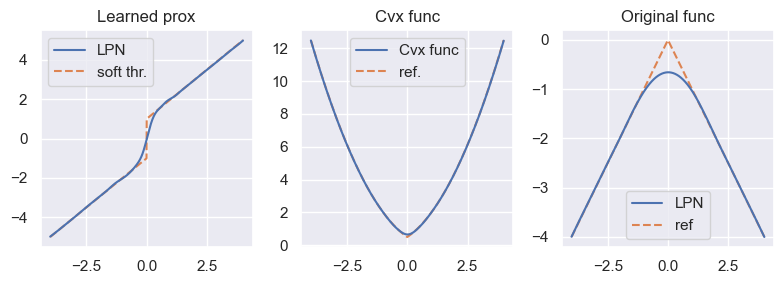

In [42]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

loss_type = 1

for i in range(1):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(40000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

## Proximal matching loss

We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma=10

iteration 0 loss 0.3711574673652649
iteration 500 loss 0.0005387544515542686
iteration 1000 loss 7.944345270516351e-05
iteration 1500 loss 3.973841739934869e-05
iteration 2000 loss 2.311706521140877e-05
iteration 2500 loss 1.385182167723542e-05
iteration 0 loss 8.318722393596545e-06
iteration 500 loss 7.802545951562934e-06
iteration 1000 loss 7.223487045848742e-06
iteration 1500 loss 6.571709946001647e-06
iteration 2000 loss 5.884766778763151e-06
iteration 2500 loss 5.2067639444430824e-06
mse 5.345176696777344
mse 0.9858322739601135
mse 0.6225481629371643
mse 0.41151201725006104
mse 0.29846400022506714
mse 0.15203721821308136
mse 0.06299905478954315
mse 0.02702050283551216
mse 0.010802813805639744
mse 0.003903263481333852
final mse 0.0013035426381975412
(1000,) (1000,) (1000,) (1000,)


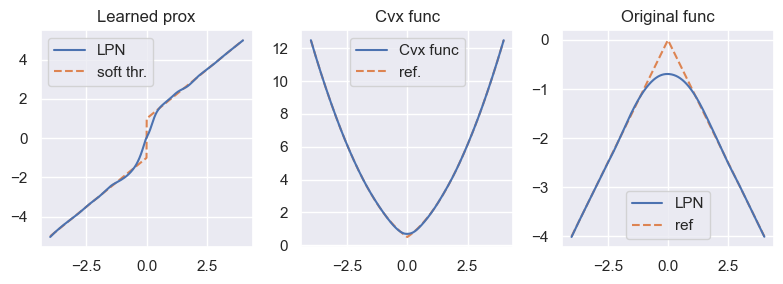

In [43]:
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

loss_type = 0
gamma_loss = 10

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-3

for i in range(3000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(3000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=5

iteration 0 loss 1.8142462067771703e-05
iteration 500 loss 1.27381090351264e-05
iteration 1000 loss 9.283721738029271e-06
iteration 1500 loss 6.98536632626201e-06
iteration 2000 loss 5.849599801877048e-06
iteration 2500 loss 5.127191343490267e-06
iteration 3000 loss 4.404485025588656e-06
iteration 3500 loss 3.828406534012174e-06
iteration 4000 loss 9.019672688737046e-06
iteration 4500 loss 3.19093464895559e-06
iteration 5000 loss 3.0061603411013493e-06
iteration 5500 loss 2.8127431050961604e-06
mse 5.345684051513672
mse 1.2272230386734009
mse 0.9135477542877197
mse 0.6730827689170837
mse 0.4125613272190094
mse 0.23355117440223694
mse 0.11787933111190796
mse 0.05791565403342247
mse 0.028189588338136673
mse 0.0129181994125247
final mse 0.005520771257579327
(1000,) (1000,) (1000,) (1000,)


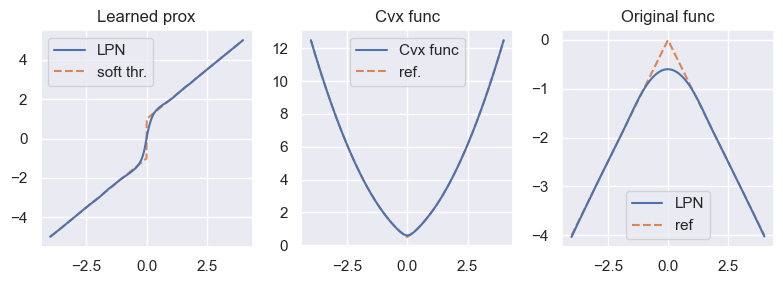

In [44]:
gamma_loss = 5

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(6000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=1

iteration 0 loss 6.488919461844489e-05
iteration 500 loss 6.33117524557747e-05
iteration 1000 loss 6.156950985314324e-05
iteration 1500 loss 5.961865099379793e-05
iteration 2000 loss 5.7472883781883866e-05
iteration 2500 loss 5.517482713912614e-05
iteration 3000 loss 5.2764116844628006e-05
iteration 3500 loss 5.115687963552773e-05
iteration 4000 loss 4.9959122407017276e-05
iteration 4500 loss 4.858106331084855e-05
iteration 5000 loss 4.703462036559358e-05
iteration 5500 loss 4.615515354089439e-05
iteration 6000 loss 4.529207944869995e-05
iteration 6500 loss 4.428505781106651e-05
iteration 7000 loss 4.3128729885211214e-05
iteration 7500 loss 4.253059523762204e-05
iteration 8000 loss 4.186660225968808e-05
iteration 8500 loss 4.108011853531934e-05
iteration 9000 loss 4.102677121409215e-05
iteration 9500 loss 3.9808750443626195e-05
mse 5.345512390136719
mse 1.2819968461990356
mse 1.0014609098434448
mse 0.7572700381278992
mse 0.45218342542648315
mse 0.26122143864631653
mse 0.144008919596672

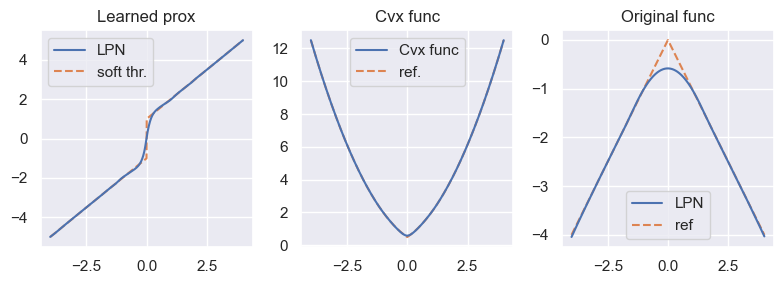

In [45]:
gamma_loss = 1

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(10000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)